<a href="https://colab.research.google.com/github/MariaCamilaPatinoJaramillo/Signal-3/blob/main/Miniproyecto_entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miniproyecto 1 analisis de señales EMG y extraccion de caracteristicas 

* **Jesus David Restrepo Martinez**

* **Daniel Arturo Vega Hernandez**

* **Maria Camila Patiño Jaramillo**

**Tratamiento de Señales III**

*Universidad de Antioquia*

*Prof. Hernán Felipe García Arias, PhD*

2021-2


Enlaces con documentacion de interes: 
- http://www4.ujaen.es/~mvalba/documentacion/tema2.pdf
- https://curiosoando.com/que-son-los-percentiles
- https://support.minitab.com/es-mx/minitab/18/help-and-how-to/statistics/basic-statistics/how-to/store-descriptive-statistics/interpret-the-statistics/interpret-the-statistics/#:~:text=elevada%20al%20cuadrado.-,Interpretaci%C3%B3n,la%20varianza%20en%20la%20pr%C3%A1ctica.

#Enlace al repositorio: https://github.com/MariaCamilaPatinoJaramillo/Signal-3

# Primera parte para la extraccion de caracteristicas y creacion de la matriz para la señal completa 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [ ]:
ruta = '/content/drive/MyDrive/Miniproyecto-Señales3/'
data = loadmat(ruta+'S1_20140620T021349.mat')

In [ ]:
ruta = '/content/drive/MyDrive/Miniproyecto-Señales3/'
data = loadmat(ruta+'S2_20140623T203911.mat')

In [ ]:
ruta = '/content/drive/MyDrive/Miniproyecto-Señales3/'
data = loadmat(ruta+'S3_20140623T192807.mat')

In [ ]:
# Llave para acceder al diccionario y obtener los datos correspondientes a EMG
print('Keys: ',data.keys())

data_EMG = data['data_EMG']
fs = 4e3
Ts = 1./fs

print('N (length),\t N_Class\t Trials: ',np.shape(data_EMG) )



Keys:  dict_keys(['__header__', '__version__', '__globals__', 'data_ACC', 'data_EMG'])
N (length),	 N_Class	 Trials:  (20000, 6, 189)


In [ ]:
def featureExtractionEMG(sampleSignal):
  # Esta función toma como argumento de entrada una señal EMG de 20000 muestras y retorna 13 caracteristicas relacionadas a la señal
  # a. Removemos el nivel DC
  nivelDC = np.mean(sampleSignal)
  sampleSignal = sampleSignal-nivelDC
  # b. Normalicemos las señales para que tengan amplitud unitaria
  maxSignal = np.abs(np.max(sampleSignal))
  sampleSignal = sampleSignal/maxSignal
  # Realicemos el análisis STFT
  f, t, Zxx = signal.stft(sampleSignal, fs, nperseg=600)

  rms = np.sqrt((np.sum(sampleSignal)**2)/len(sampleSignal))
  mae = np.sum(np.abs(sampleSignal))/len(sampleSignal)
  # En la matriz Zxx se tiene una matriz de #defrecs * #times
# Zxx[i,j], sería el espectro en la frecuencia[i] y el tiempo [j]
  absZxx = np.abs(Zxx)
  Pmax_Zxx = np.max(absZxx,axis=1) # dB

#Para calcular los cruces por cero
  i=0
  cont=0
  for n in range (0,(len(sampleSignal)-1)):
    if( (sampleSignal[n]>0 and sampleSignal[n+1]<0) or (sampleSignal[n]<0 and sampleSignal[n+1]>0)):
      cont=i+1
      i=i+1
    else:
      cont=i+0

  Pmax_Zxx_dB = 20*np.log10(Pmax_Zxx)
  idx = np.argsort(Pmax_Zxx_dB)
  maximos = Pmax_Zxx_dB[idx]
  auxPot = maximos[-5:]
  frecuencias = f[idx]
  fPmax_Zxx = frecuencias[-5:]
  feature_set = np.zeros((13,))
  feature_set[0] = rms
  feature_set[1] = mae
  feature_set[2:7] = auxPot
  feature_set[7:12] = fPmax_Zxx
  feature_set[12]=cont
  return feature_set

In [ ]:
# Las dimensiones de data EMG corresponden a 20000,6,189 donde:
#20000 corresponde a los datos
# 6 el tipo de movimiento
# 189 el numero de intentos por ese movimiento 

#lo que se esta haciendo es crear la matriz de caracteristicas para toda la señal x y tambien se crea un vector columna que representa el tipo de movimiento T
L_Signal, Classes, Ntrials = np.shape(data_EMG)
D = 13 # número de características

X = np.zeros((Classes*Ntrials,D))
t = np.zeros((Classes*Ntrials,1))
pos = 0
for clase in range(0,Classes):
  for n in range(0,Ntrials):
    sampleSignal = data_EMG[:,clase,n]
    # Luego le extraemos las D características a cada señal del experimento
    x_n = featureExtractionEMG(sampleSignal)
    X[pos, :] = x_n
    t[pos] = clase
    pos = pos + 1

In [ ]:
#Aqui ya tenemos la señal original con todas las caracteristicas que serian 13 

print(np.shape(X))

(1134, 13)


# Segunda parte usando las funciones de wavelet, extraccion de caracteristicas y formacion matriz gigante

In [ ]:
import pywt  #nombre de la libreria 
import numpy as np
data =sampleSignal
np.shape(data)

(20000,)

Para la parte de las funciones wavelet se va a crear una matriz que va a tener 
+ N filas : que corresponden a los niveles de descomposicion 
+ 2 columnas: donde una van a ser los coeficientes de aproximacion(Pasaaltas) y la otra los coeficientes de detalle (Pasabajas)  

In [ ]:
import scipy 
from scipy.stats import entropy
!pip install antropy
import antropy as ant

def calculate_entropy(list_values):
  entropy_val =ant.perm_entropy(signal, normalize=True)
  return entropy_val

def calculate_statistics(list_values):
  n5 = np.nanpercentile(list_values, 5)
  n25 = np.nanpercentile(list_values, 25)
  n75 = np.nanpercentile(list_values, 75)
  n95 = np.nanpercentile(list_values, 95)
  median = np.nanpercentile(list_values, 50)
  mean = np.nanmean(list_values)
  std = np.nanstd(list_values)
  var = np.nanvar(list_values)
  rms = np.nanmean(np.sqrt(list_values**2))
  return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
  zero_crossing_indices = np.where(np.diff(np.signbit(list_values)))[0]
  no_zero_crossings = len(zero_crossing_indices)
  mean_crossing_indices = np.where(np.diff(np.signbit(list_values-np.nanmean(list_values))))[0]
  no_mean_crossings = len(mean_crossing_indices)
  return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
  entropy = calculate_entropy(list_values)
  crossings = calculate_crossings(list_values)
  statistics = calculate_statistics(list_values)
  return [entropy] + crossings + statistics

  

# PARA LA DESCOMPOSICION #1 

In [ ]:
import pywt
import numpy as np
import sys


X_1 = np.zeros((Classes*Ntrials,12))
X_1_1 = np.zeros((Classes*Ntrials,12))
t_1 = np.zeros((Classes*Ntrials,1))
pos=0
bu=[]
for clase in range(0,Classes):
  for n in range(0,Ntrials):
    signal = data_EMG[:,clase,n]
     
    nDesc =1
    waveletname1 = 'db'+str(nDesc)

    
    (data, coeff_d) = pywt.dwt(signal, waveletname1)
    conjunto1Features1 = get_features(data)
    conjunto1Features1_1 = get_features(coeff_d)
    X_1[pos, :] = conjunto1Features1
    X_1_1[pos,:]=conjunto1Features1_1
    t_1[pos] = clase
    pos = pos + 1

data_des1=data

  


In [ ]:

np.set_printoptions(threshold=sys.maxsize)
print(np.shape(X_1))
#print(X_1)



(1134, 12)


# Para la descomposicion #2

In [ ]:
import pywt
import numpy as np
import sys


X_2 = np.zeros((Classes*Ntrials,12))
t_2 = np.zeros((Classes*Ntrials,1))
pos=0
data_des2=[]

signal1 = data_des1
     
nDesc =2
waveletname2 = 'db'+str(nDesc)
for clase in range(0,Classes):
  for n in range(0,Ntrials):
    
    (data1, coeff_d) = pywt.dwt(signal1, waveletname2)
    conjunto1Features2 = get_features(data1)
    X_2[pos, :] = conjunto1Features2
    t_2[pos] = clase
    pos = pos + 1
    
  data_des2=data1

#Descomposicion #3

In [ ]:
import pywt
import numpy as np
import sys

X_3 = np.zeros((Classes*Ntrials,12))
t_3 = np.zeros((Classes*Ntrials,1))
pos=0
data_des3=[]

signal2 = data_des2
nDesc =3
waveletname3 = 'db'+str(nDesc)
for clase in range(0,Classes):
  for n in range(0,Ntrials):
    
    (data2, coeff_d) = pywt.dwt(signal2, waveletname3)
    conjunto1Features3 = get_features(data2)
    X_3[pos, :] = conjunto1Features3
    t_3[pos] = clase
    pos = pos + 1
    
  data_des3=data2


# Ya se tienen la matriz de caracteristicas para las 3 descomposiciones de la funciones Wavelet

Impresion de los tamaños de cada matriz de caracteristicas


In [ ]:
print(np.shape(X))  #vector de caracteristicas de la señal original
print(np.shape(X_1_1)) # vector de caracteristicas para la primera descomposicion de los coef de pasa altas
print(np.shape(X_1)) # vector de caracteristicas para la primera descomposicion
print(np.shape(X_2))  # vector de caracteristicas para la segunda descomposicion
print(np.shape(X_3))  # vector de caracteristicas para la tercera descomposicion

(1134, 13)
(1134, 12)
(1134, 12)
(1134, 12)
(1134, 12)


In [ ]:
# Importa pandas 
import pandas as pd
matriz_completa=np.concatenate((X,X_1,X_2,X_3,X_1_1,t_1), axis=1)
print(np.shape(matriz_completa))



(1134, 62)


#Generacion del super vector con todas las caracteristicas de las señanes EMG 



In [ ]:
# Importa pandas 
import pandas as pd  
Nombres = ['RMS','MAE','P1','P2','P3','P4','P5','F1','F2','F3','F4','F5','Num Cruces Por Cero','Entropia w1', 'Cruces por cero w1', 'Cruce con la media w1', 'Percentil 5 w1','Percentil 25 w1','Percentil 75 w1','Percentil 95 w1','Mediana w1','Media w1','Std w1', 'Varianza w1', 'RMS w1','Entropia w2', 'Cruces por cero w2', 'Cruce con la media w2', 'Percentil 5 w2','Percentil 25 w2','Percentil 75 w2','Percentil 95 w2','Mediana w2','Media w2','Std w2', 'Varianza w2', 'RMS w2','Entropia w3', 'Cruces por cero w3', 'Cruce con la media w3', 'Percentil 5 w3','Percentil 25 w3','Percentil 75 w3','Percentil 95 w3','Mediana w3','Media w3','Std w3', 'Varianza w3', 'RMS w3','Entropia w_1_1', 'Cruces por cero w_1_1', 'Cruce con la media w_1_1', 'Percentil 5 w_1_1','Percentil 25 w_1_1','Percentil 75 w_1_1','Percentil 95 w_1_1','Mediana w_1_1','Media w_1_1','Std w_1_1', 'Varianza w_1_1', 'RMS w_1_1','Tipo de Mov']

dataFrame = pd.DataFrame(data = matriz_completa,columns= Nombres)


# Creacion de dataframe 


In [ ]:
dataFrame

,RMS,MAE,P1,P2,P3,P4,P5,F1,F2,F3,F4,F5,Num Cruces Por Cero,Entropia w1,Cruces por cero w1,Cruce con la media w1,Percentil 5 w1,Percentil 25 w1,Percentil 75 w1,Percentil 95 w1,Mediana w1,Media w1,Std w1,Varianza w1,RMS w1,Entropia w2,Cruces por cero w2,Cruce con la media w2,Percentil 5 w2,Percentil 25 w2,Percentil 75 w2,Percentil 95 w2,Mediana w2,Media w2,Std w2,Varianza w2,RMS w2,Entropia w3,Cruces por cero w3,Cruce con la media w3,Percentil 5 w3,Percentil 25 w3,Percentil 75 w3,Percentil 95 w3,Mediana w3,Media w3,Std w3,Varianza w3,RMS w3,Entropia w_1_1,Cruces por cero w_1_1,Cruce con la media w_1_1,Percentil 5 w_1_1,Percentil 25 w_1_1,Percentil 75 w_1_1,Percentil 95 w_1_1,Mediana w_1_1,Media w_1_1,Std w_1_1,Varianza w_1_1,RMS w_1_1,Tipo de Mov
0,2.311176e-15,0.294098,-25.461826,-22.838421,-21.593740,-13.185073,-13.159219,106.666667,40.000000,60.000000,53.333333,46.666667,535.0,0.616959,565.0,533.0,-0.022703,-0.004099,0.061013,0.080780,0.028690,0.028736,0.035547,0.001264,0.037181,0.563345,732.0,738.0,-0.276105,-0.10163,0.121125,0.28123,0.009658,0.007008,0.19219,0.036937,0.138983,0.563345,690.0,678.0,-0.382561,-0.14366,0.173389,0.396422,0.015627,0.010134,0.267856,0.071747,0.195704,0.616959,1660.0,1649.0,-0.003023,-0.001395,0.001395,0.003023,0.000000,1.209234e-06,0.001860,0.000003,0.001506,0.0
1,7.492481e-15,0.316546,-23.777920,-21.882633,-20.762850,-12.560300,-12.426907,100.000000,40.000000,60.000000,46.666667,53.333333,540.0,0.608746,538.0,538.0,-0.022470,-0.003402,0.060083,0.079849,0.027992,0.028447,0.034821,0.001213,0.036600,0.563345,732.0,738.0,-0.276105,-0.10163,0.121125,0.28123,0.009658,0.007008,0.19219,0.036937,0.138983,0.563345,690.0,678.0,-0.382561,-0.14366,0.173389,0.396422,0.015627,0.010134,0.267856,0.071747,0.195704,0.608746,1514.0,1520.0,-0.002791,-0.001395,0.001395,0.002791,0.000000,2.116159e-06,0.001813,0.000003,0.001473,0.0
2,1.218392e-15,0.263807,-24.561016,-23.143446,-21.286972,-13.982896,-13.716889,80.000000,40.000000,60.000000,53.333333,46.666667,576.0,0.617770,554.0,566.0,-0.023866,-0.004099,0.058920,0.081942,0.027527,0.028184,0.035760,0.001279,0.036930,0.563345,732.0,738.0,-0.276105,-0.10163,0.121125,0.28123,0.009658,0.007008,0.19219,0.036937,0.138983,0.563345,690.0,678.0,-0.382561,-0.14366,0.173389,0.396422,0.015627,0.010134,0.267856,0.071747,0.195704,0.617770,1670.0,1664.0,-0.003023,-0.001395,0.001395,0.003023,0.000000,4.488117e-06,0.001961,0.000004,0.001565,0.0
3,2.700559e-15,0.236866,-24.106740,-22.832281,-22.349908,-14.643568,-14.472559,66.666667,60.000000,40.000000,46.666667,53.333333,608.0,0.642996,632.0,594.0,-0.024796,-0.002239,0.057293,0.081245,0.027294,0.027793,0.035071,0.001230,0.036288,0.563345,732.0,738.0,-0.276105,-0.10163,0.121125,0.28123,0.009658,0.007008,0.19219,0.036937,0.138983,0.563345,690.0,678.0,-0.382561,-0.14366,0.173389,0.396422,0.015627,0.010134,0.267856,0.071747,0.195704,0.642996,2013.0,2013.0,-0.003488,-0.001395,0.001395,0.003488,0.000000,-4.557880e-06,0.002180,0.000005,0.001716,0.0
4,1.984597e-15,0.280108,-23.311912,-21.536340,-20.635537,-13.342430,-13.037959,66.666667,60.000000,40.000000,53.333333,46.666667,642.0,0.638023,630.0,620.0,-0.027121,-0.003634,0.057293,0.084035,0.027527,0.027512,0.036399,0.001325,0.037011,0.563345,732.0,738.0,-0.276105,-0.10163,0.121125,0.28123,0.009658,0.007008,0.19219,0.036937,0.138983,0.563345,690.0,678.0,-0.382561,-0.14366,0.173389,0.396422,0.015627,0.010134,0.267856,0.071747,0.195704,0.638023,1898.0,1898.0,-0.003721,-0.001395,0.001395,0.003721,0.000000,-5.813623e-07,0.002236,0.000005,0.001763,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,4.616072e-16,0.176549,-22.046743,-21.697849,-21.176839,-17.936285,-17.292164,120.000000,86.666667,93.333333,53.333333,46.666667,679.0,0.555216,661.0,675.0,-0.138975,-0.066886,0.079617,0.148927,0.0084

Para la parte de las graficas y analisis fue necesario tomar grupos de caracteristicas mas reducidos, ya que la matriz de datos es muy grande y por lo tanto no es posible hacer una grafica completa del dataframe 

**Analisis para el numero de cruces por cero señal original-descomposiciones** 

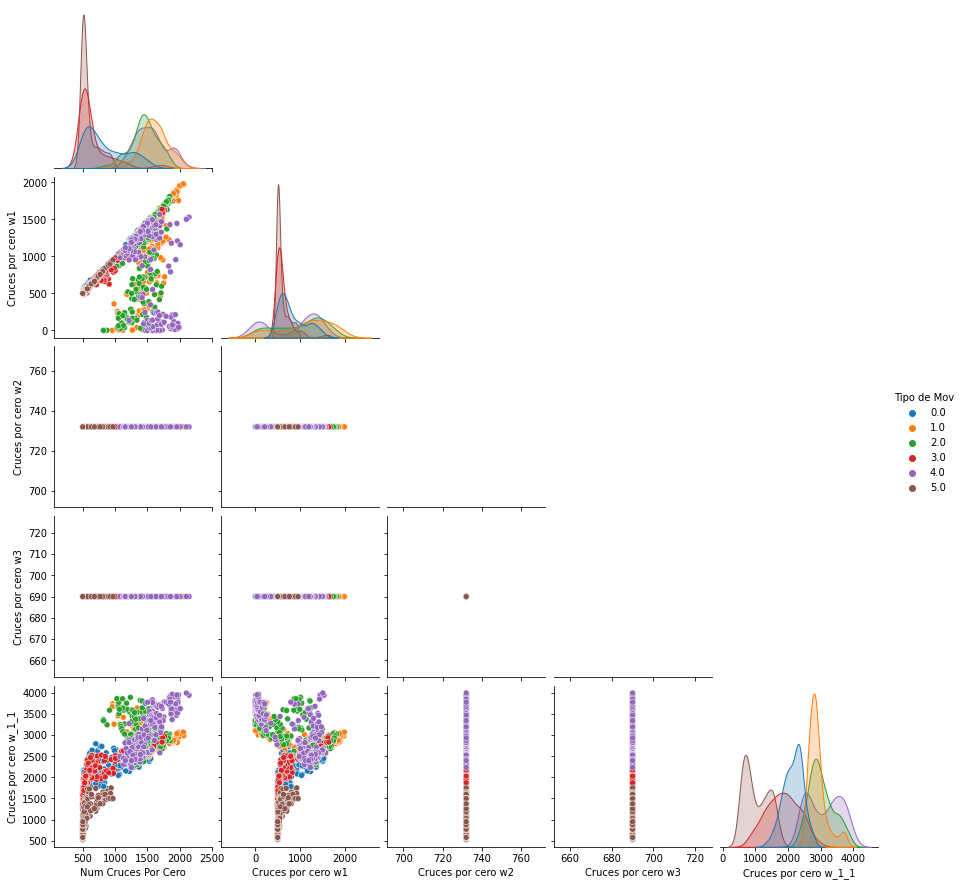

In [ ]:
import seaborn as sns
subDataFrame = dataFrame[['Num Cruces Por Cero','Cruces por cero w1','Cruces por cero w2','Cruces por cero w3', 'Cruces por cero w_1_1', 'Tipo de Mov']]
subSet = dataFrame
unique = subSet["Tipo de Mov"].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
sns.pairplot(subDataFrame, hue = "Tipo de Mov",corner=True, palette=palette)

**Observaciones:**
- El numero de cruces por cero es una caracteristica que puede ser importante ya que es una forma sencilla de medir la frecuencia de la señal 
- En esta grafica se esta haciendo una comparacion entre los cruces por cero para la señal original y para los niveles de descomposicion, en la mayoria de estas graficas no fue posible observar una sepacion o un agrupamiento que permita identificar el tipo de movimiento a excepcion de cuando se hace:
  - El numero de cruces por cero vs el numero de cruces por cero de los coeficientes de detalle de la transformada wavelet-, en esta grafica se observan como los movimientos correspondientes al 3, 4 y 5 forman pequeños grupos en ciertas zonas, lo que permite hacer una distincion de estas clases sobre las demas que no son posible de identificar 
  - Otra de las graficas que llama la atencion en la comparacion entre los coeficientes de detalle y los coeficientes de aproximacion para los cruces por cero del primer nivel de descomposicion, aqui es posible observar que los datos que corresponden al movimiento 5 estan mucho mas agrupados y concentrados en un unica zona, contrario de los demas que se encuentran un poco mas dispersos jy es posible ver como se sobreponen unos con otros, en especial los correspondientes al movimiento 4 que presentan un agrupamiento menor al grafico anterior pero se ve que el solapamiento y la acumulacion de datos en determinadas zonas no permite ver las observaciones correspondientes a los movimientos 0 y 1 




**Analisis potencias y frecuencia señal original**

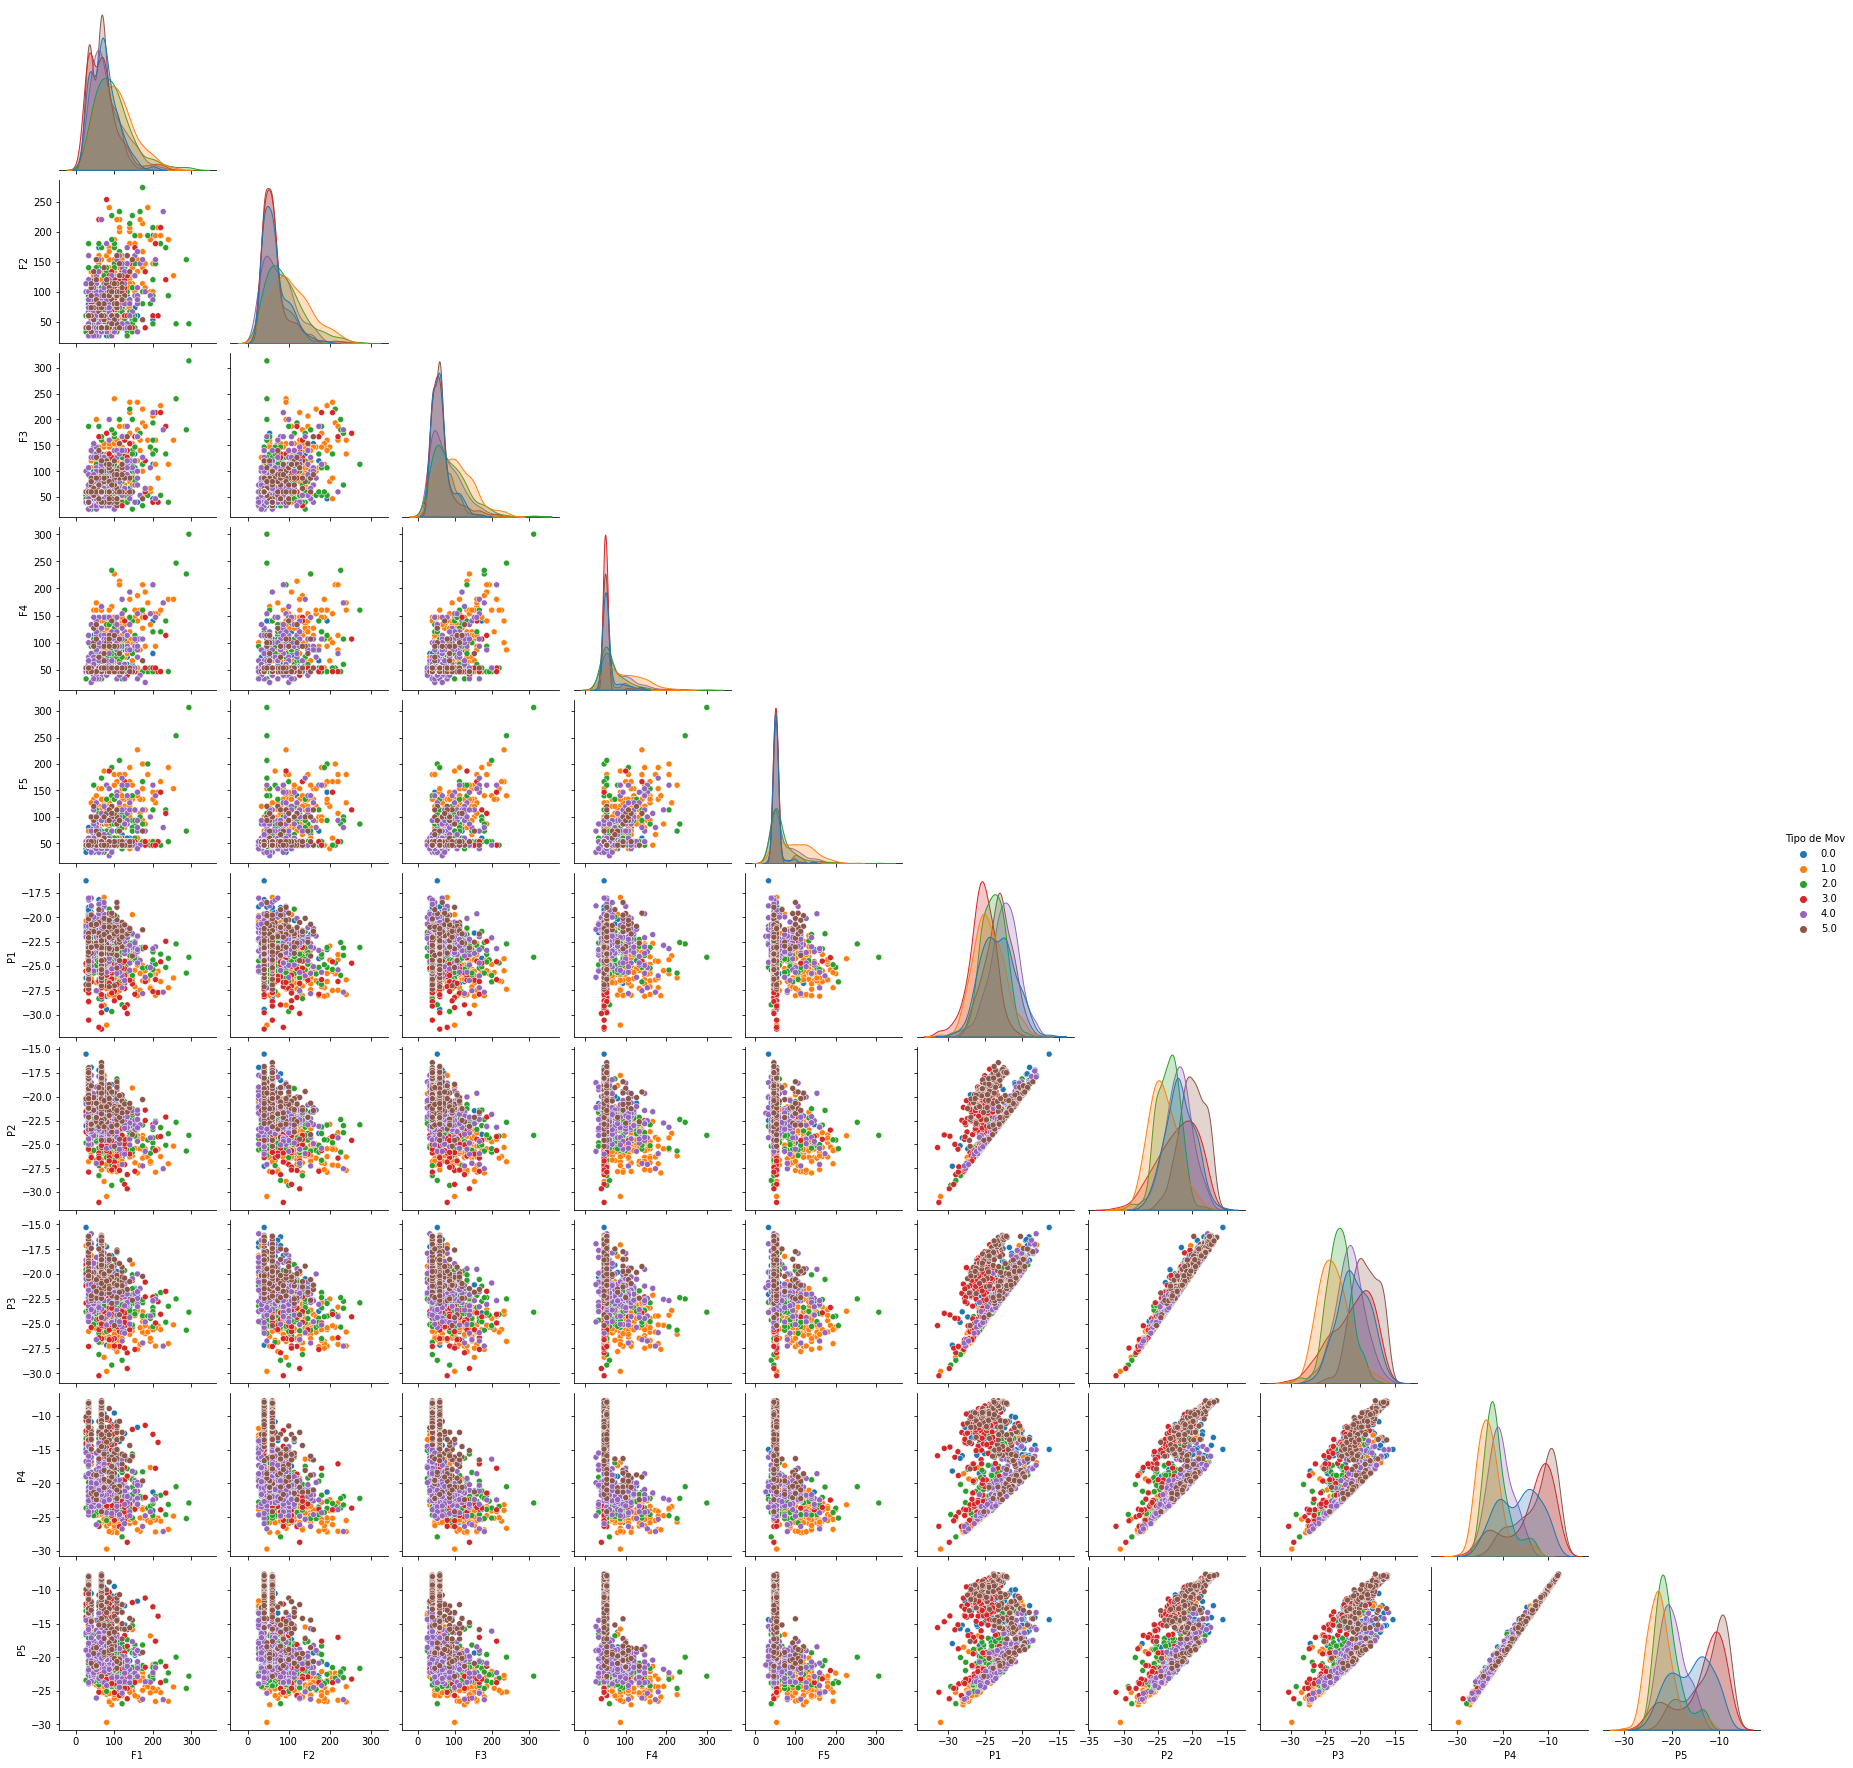

In [ ]:
import seaborn as sns
subDataFrame2 = dataFrame[['F1','F2','F3','F4','F5','P1','P2','P3', 'P4', 'P5','Tipo de Mov']]
sns.pairplot(subDataFrame2, hue = "Tipo de Mov",corner=True, palette=palette)

**Observaciones:**
- El hacer una comparacion entre las frecuecias correspondientes a la potencia de la señal original no es posible hacer una segmentacion o notar uno de los movimientos mas que los otros, esto se debe a es posible que los valores de frecuencia asociados a la potencia sean muy similares para los movimientos, por lo cual no es posible hacer una distincion
- Al hacer el versus entre valores de potencia para la señal original es posible observar que el movimiento 5 es tiende a concentrarce en la misma zona para todas las distribuciones bivariantes que corresponden a potencia vs potencia, lo anterior se podria dar ya que el valor de potencia lo podemos asociar a al nivel de fuerza con el que se esta realizando el movimiento, lo cual indica que el que mayor fuerza requiere o se hizo para las observaciones corresponde al movimiento 5 


**Analisis de percentil primera descomposicion con las potencias**

---



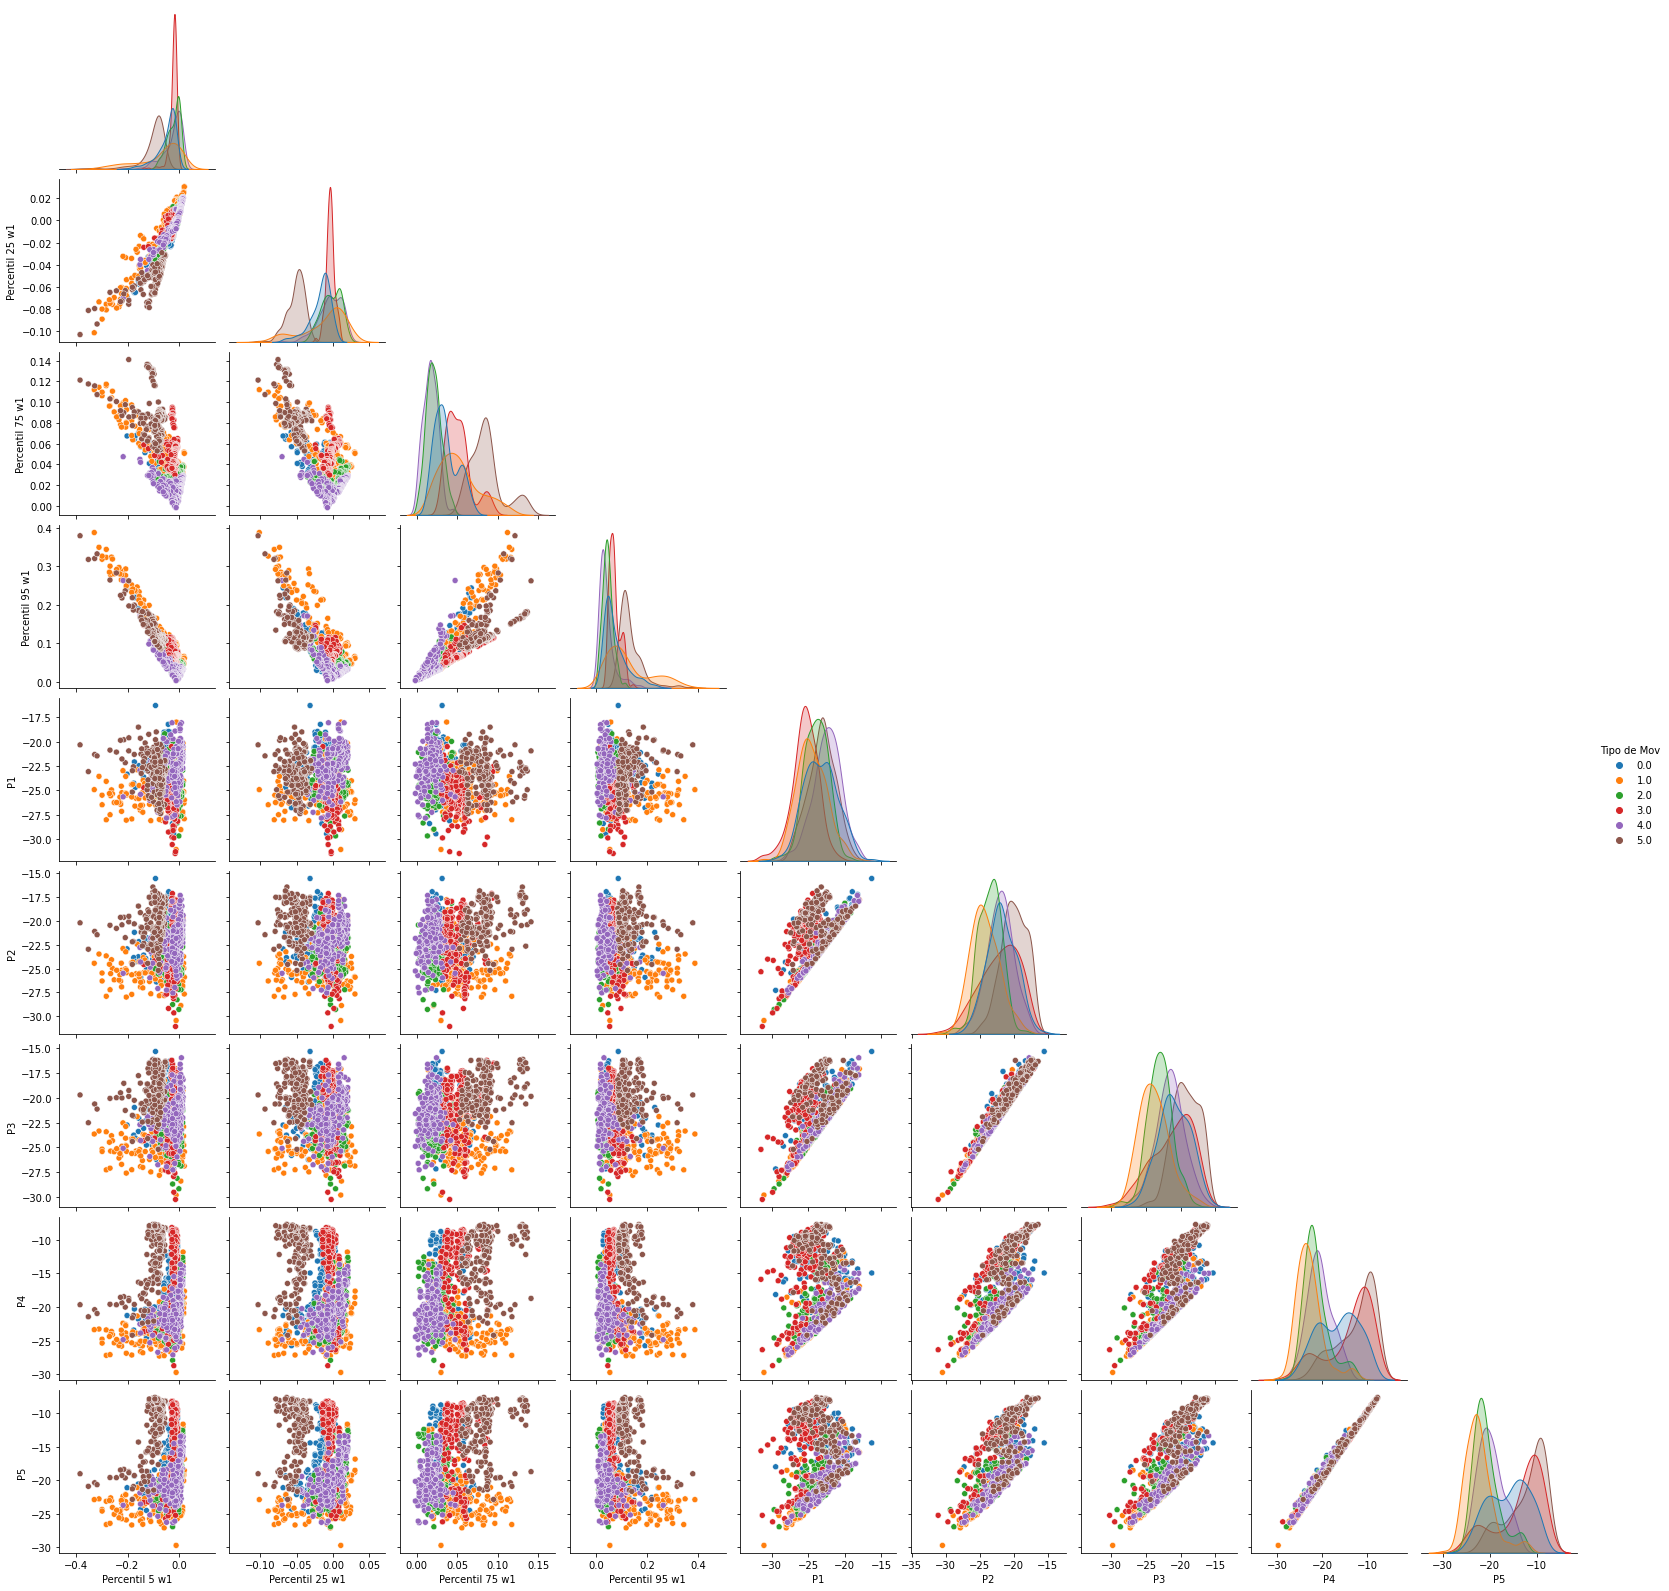

In [ ]:
import seaborn as sns
subDataFrame3 = dataFrame[['Percentil 5 w1','Percentil 25 w1','Percentil 75 w1','Percentil 95 w1','P1','P2','P3', 'P4', 'P5','Tipo de Mov']]
sns.pairplot(subDataFrame3, hue = "Tipo de Mov",corner=True, palette=palette)


**Observaciones:**

  - Los percentiles son una medida estadística que se utiliza para comparar los datos evaluados entre si y nos indica el porcentaje de datos que son igual o menor que un determinado valor. Se toma como estrategia hacer una comparacion entre los percentiles y la potencia para observar los focos de concentracion de las señales y su potencia. Con esta estrategia se logra identificar bien las señales cuando se hacen las respectivas comparaciones.

  -El mejor ejemplo es la comparacion del percentil 75 w1 versus p5 p4 p3 p2 p1, mostrando claramente la separacion de los moviminetos aunque el azul y el verde no se evidencien claramente se puede tener una idea de su concentracion por sus valores independientes. Los valores morado rojo naranja cafe si tienen una fuerte agrupacion definida que los identifica claramente, mostrando asi que la comparacion entre estas variables de percentil y potencias son una buena eleccion para la separacion de los movimientos.

  -Las relaciones de los datos de potencias y percentiles entre ellas mismas no aportan informacion ya que los datos se agrupan mucho entre ellos y no es claro identificar algun patron o agrupamiento de los movimientos por eso, se descartan esas y se opta por las graficas de potencia versus percentiles.




**Analisis para el RMS señal original-descomposiciones* y MAE**


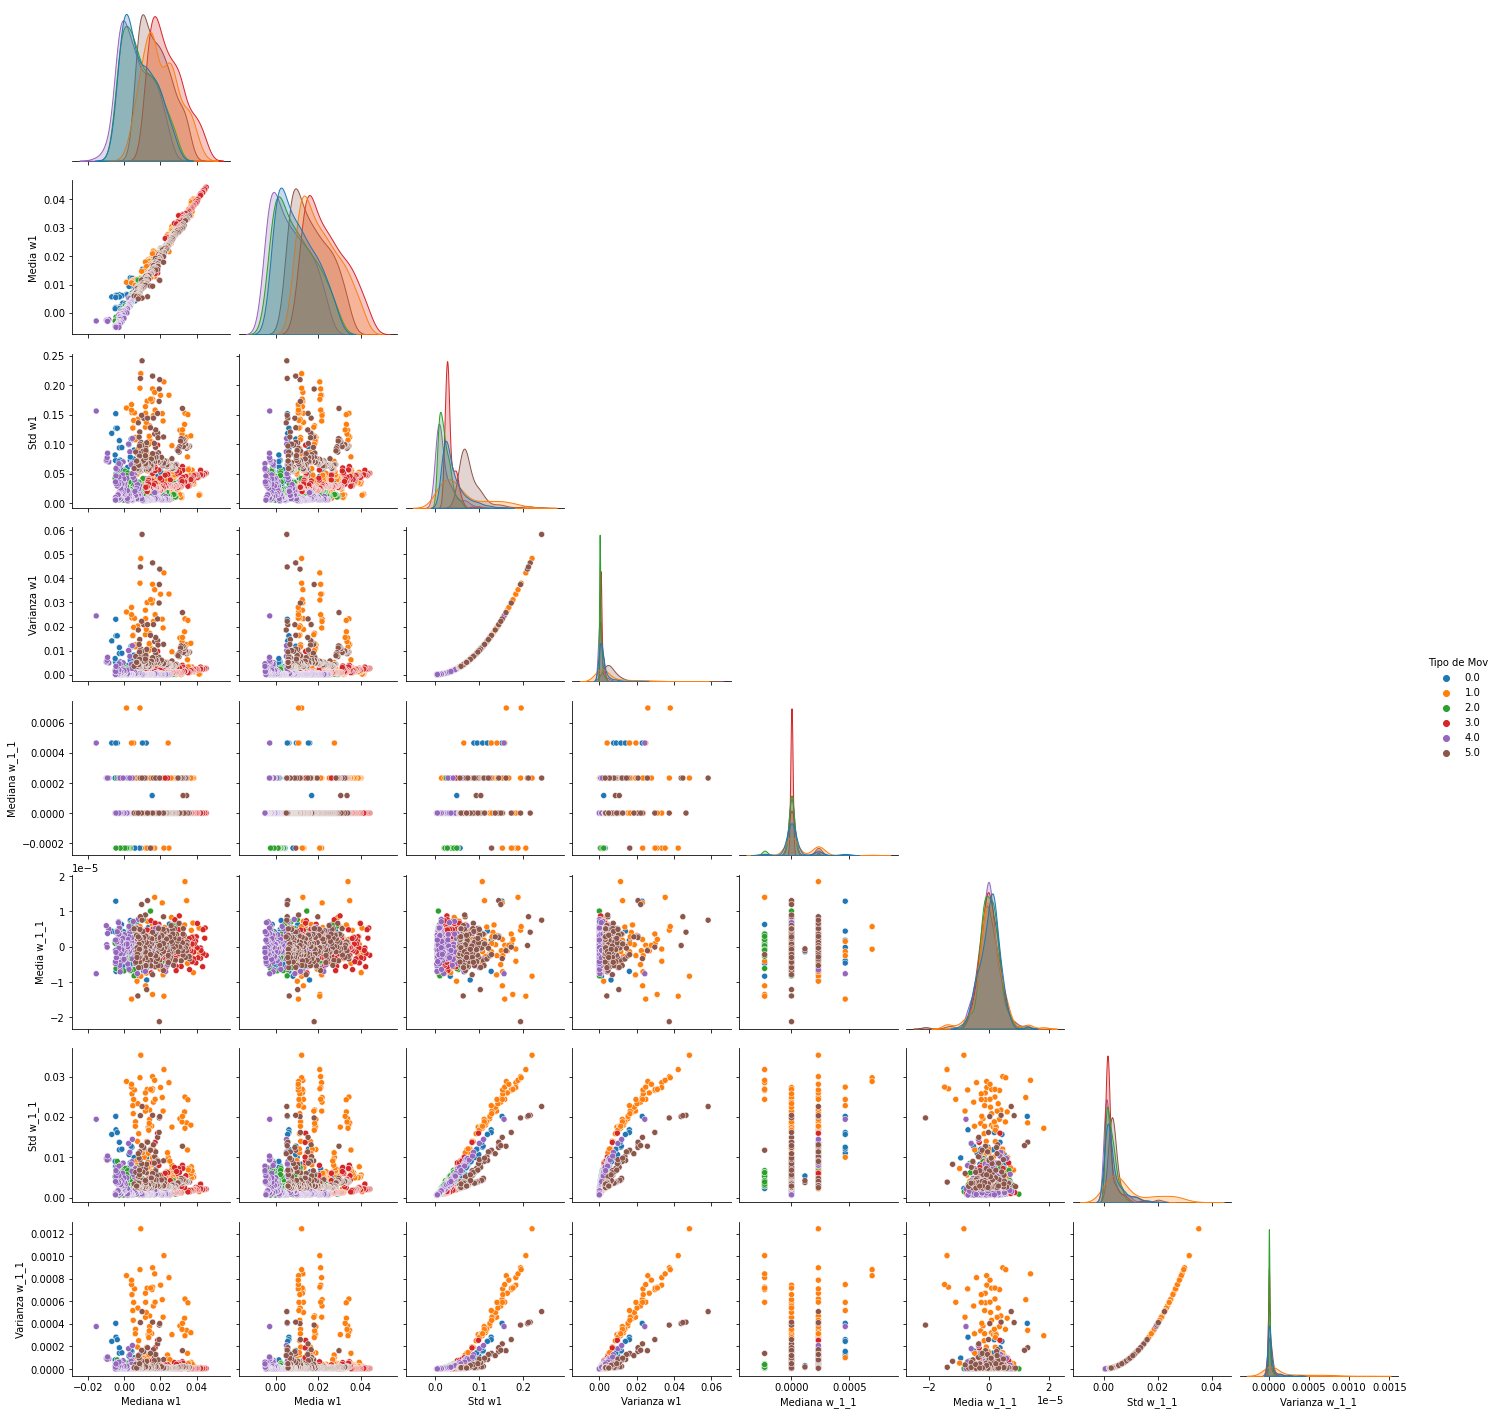

In [ ]:
import seaborn as sns

subDataFrame4 = dataFrame[['Mediana w1','Media w1','Std w1', 'Varianza w1', 'Mediana w_1_1','Media w_1_1','Std w_1_1', 'Varianza w_1_1' ,'Tipo de Mov']]
sns.pairplot(subDataFrame4, hue = "Tipo de Mov",corner=True, palette=palette)


**Observaciones:**

- La varianza y la desviacion estandar son valores que hablan de que tan dispersos estan los datos con respecto a la media por lo cual con esta informacion y con las graficas no es posible hacer una identificacion inequivoca de las clases de movimientos, lo unico que es posible es observar que los movimientos que corresponden a las clases 4 y 5 se concentran en la parte baja de la grafica 
- Cuando se hace un analisis de la media y la mediana que son medidas de tendencia central es posible hacer una identificacion de los movimientos que corresponden a las clases 4 y 5, esto se puede decir que se da porque estas medidad tratan de tomar un conjunto completo de valores y dar un valor promedio que resuma todo su valor, lo que permite que entre valores que tienen una similitud como es la clase de movimiento exista una concentracion que permita hacer esa identificacion, con esto asumimos que los valores promedio de los movimientos inferiores correspondientes a las clases 0,1,2 y 3 tienen unos valores promedio menores lo que hace que no se vean mucho en las graficas 
- El comportamiento en las graficas del movimiento 1 nos parece muy llamativo, ya que este tiene una tendencia lineal en la mayoria de las graficas 
- El movimiento cero es el que menos se nota en implementacion de las graficas por lo cual concluimos que es el menos distinguible de todos 


#**Análisis de las características con respecto a los coef de detalle**

**RMS, MAE, Cruces por cero y Entropía**

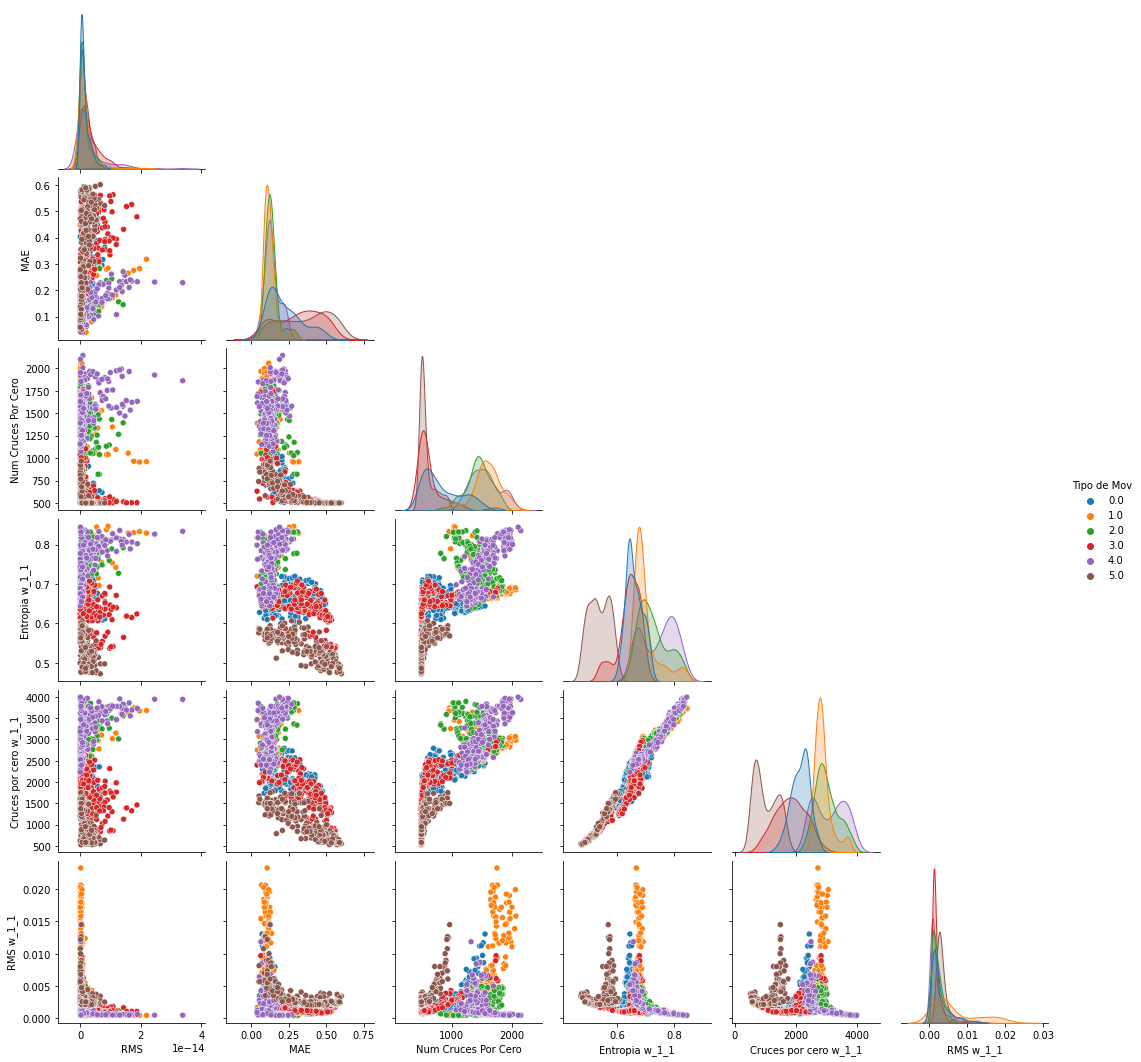

In [ ]:
import seaborn as sns
subDataFrame5 = dataFrame[['RMS','MAE','Num Cruces Por Cero','Entropia w_1_1', 'Cruces por cero w_1_1', 'RMS w_1_1','Tipo de Mov']]
#,'P1','P2','P3','P4','P5','F1','F2','F3','F4','F5'
sns.pairplot(subDataFrame5, hue = "Tipo de Mov",corner=True, palette=palette)

**Observaciones**
- El valor RMS ayuda a diferenciar en gran medida los tipos de movimiento 1 ya que al tener baja esta cantidad en comparación con las demás ayuda mucho a definir un grupo en comparaciones con la entropía.
- Por otra parte, la entropía, que es una medida la cual ayuda observar el nivel de incertidumbre o ruido que tiene determinada señal, es una característica importante para diferenciar los tipos de movimiento 5 y 1, el tipo 5 por su bajo nivel de entropía y el tipo 1 por su alto nivel, en general porque tienen un nivel de entropía que resalta mucho en comparación a los otros tipos de movimiento. Aunque en cuanto a los tipos de movimiento 0 y 3 es recomendable usar otra característica distinta a la entropía para la diferenciación entre estos ya que tienen un nivel muy similar que hace difícil separar los grupos de ambos entre sí.
- Los cruces por cero que tiene cada señal hace que sea de gran ayuda para observar el tipo de movimiento 5 en partícular al tener pocos en comparación a los demás, es una buena característica sobretodo para analizar este movimiento en particular.
- Por último, el valor de MAE no ayuda mucho a diferenciar los tipos de movimiento entre las características comparadas en esta sección, razón por la cual resulta ser una característica poco fiable en para esta labor.

**Media, Mediana, Desviación estándar, Varianza**

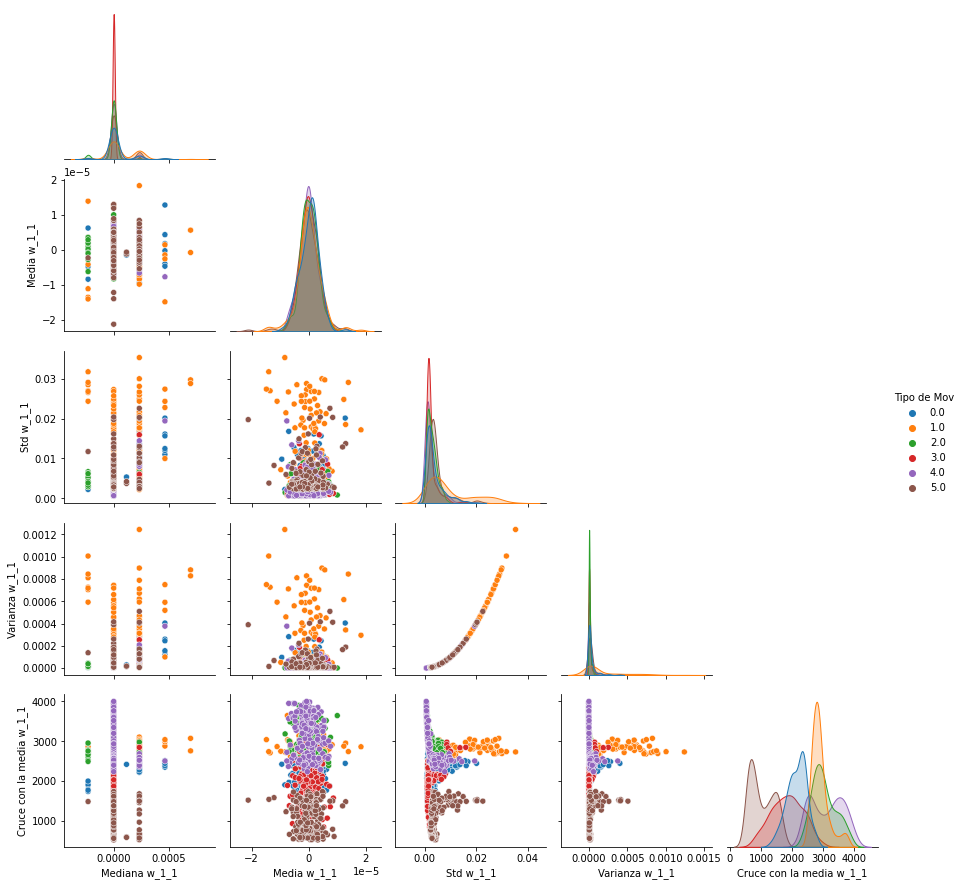

In [ ]:
import seaborn as sns
subDataFrame6 = dataFrame[['Mediana w_1_1','Media w_1_1','Std w_1_1', 'Varianza w_1_1','Cruce con la media w_1_1','Tipo de Mov']]
#,'P1','P2','P3','P4','P5','F1','F2','F3','F4','F5'
sns.pairplot(subDataFrame6, hue = "Tipo de Mov",corner=True, palette=palette)

**Observaciones**
- La media indica el valor central de los distintos tipos de movimiento, en realidad este dato no aporta un análisis para diferenciar los tipos de movimiento entre sí, es mas que todo una referencia para encontrar el verdadero análisis importante que es el cruce por la media que hace la función wavelet. De forma similar ocurre con la mediana, simplemente es un dato de referencia para medir el valor central pero no aporta información relevante para la diferenciar los tipos de movimiento entre sí.
- La desviación estándar mide el que tan dispersos se encuentran las mediciones realizadas para cada tipo de movimiento frente a su media respectivamente, este dato ayuda a observar si el grupo que contiene a un tipo de movimiento en particular es muy grande a la hora de diferenciarlos entre sí, entre mayor sea la desviación estándar más difícil será ubicar de manera correcta un tipo de movimiento en concreto puesto que podría malinterpretarse con otro movimiento al extrapolarse la información entre ellos.
- Por último, el cruce con la media de cada movimiento ayuda observar la oscilación que un dato podría tener con su valor promedio, usando esta información es posible diferenciar ciertos tipos de movimiento. Para este caso se encuentra que es más fácil de diferenciar el tipo de movimiento 1 que es quien tiene mayor cruce por su valor promedio y ya resaltando pero en menor medida también los tipos de movimiento 5 y 4 que sucede el caso contrario en donde se observa menor cruces por su valor promedio, haciendo que sean los movimiento más interesantes por analizar con ésta característica.

**Análisis Percentil**

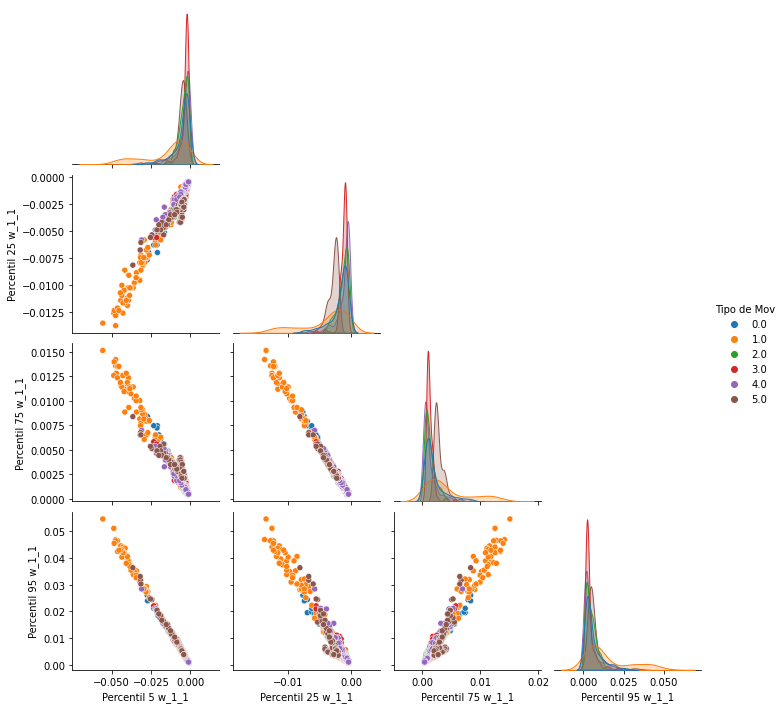

In [ ]:
import seaborn as sns
subDataFrame7 = dataFrame[['Percentil 5 w_1_1','Percentil 25 w_1_1','Percentil 75 w_1_1','Percentil 95 w_1_1','Tipo de Mov']]
#,'P1','P2','P3','P4','P5','F1','F2','F3','F4','F5'
sns.pairplot(subDataFrame7, hue = "Tipo de Mov",corner=True, palette=palette)

**Observaciones**
- Por una parte, se observa en el percentil 95 que el mayor número de movimientos detectados fue el de tipo 3 pero aunque es el de mayor concurrencia, es bastante complicado diferenciar este tipo de movmiento del resto en cuánto al análisis percentil puesto que el resto de movimientos también ocurren con un alto grado de probabilidad haciendo que este análisis no sea el mejor para la diferenciación de los datos.
- Por otra parte, el movimiento con menor percentil es el tipo 1, quiere decir que es el tipo de movimiento con menor probabilidad de ocurrencia y esto hace que se pueda observar una clara separación en cuanto a los demás tipos de movimiento haciendo que éste sea más fácil de diferenciar frente al resto.
- Este tipo de análisis es adecuado para cuando se tiene un nivel de percentil muy distinto entre los tipos de movimiento, en el caso del movimiento tipo 1 viene perfecto puesto que al tener un percentil tan bajo hace que su diferenciación sea bastante notoria facilitando el análisis de máquina para ese movimiento en concreto con este tipo de análisis.